# Direct vs ODE-Based Regression for an Over-Damped Oscillator

This notebook illustrates the ideas from Section 2.2 on **regression** and
**ODE-based modeling** using a simple over-damped oscillator:

\[
\dot{x}(t) = -\gamma x(t) + g(t), \quad g(t) = \sin t,\ \gamma = 2.
\]

We will:
- simulate noisy observations of the true solution,
- fit a **direct regression model** (polynomial in time),
- fit an **ODE-based regression model** for \(\gamma\),
- compare the resulting trajectories and parameters.

All figures are saved into the local `figs/` directory so that they can be
included in the book.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Make sure we have a place for figures
os.makedirs("figs", exist_ok=True)

# For reproducibility
rng = np.random.default_rng(123)

In [2]:
# -------------------------------------------------------------------
# Simulate data from the true ODE
#   x'(t) = -gamma_true * x(t) + sin(t)
# with known analytic solution from the text.
# -------------------------------------------------------------------
gamma_true = 2.0

def x_true(t):
    # From the text:
    # x(t) = e^{-2t} + (sin t - 2 cos t)/sqrt(5)
    return np.exp(-2*t) + (np.sin(t) - 2*np.cos(t)) / np.sqrt(5.0)

# Time grid
t = np.linspace(0.0, 5.0, 51)  # 0, 0.1, ..., 5.0
sigma = 0.5                    # noise level

x_clean = x_true(t)
noise = rng.normal(loc=0.0, scale=sigma, size=t.shape)
x_noisy = x_clean + noise

print("Number of samples:", t.size)

Number of samples: 51


## Direct Regression

We first fit a polynomial
\[
P_d(t) = a_0 + a_1 t + \dots + a_d t^d
\]
directly to the noisy data \(x(t_i)\).  
This is flexible but does not explicitly encode the differential equation.


Saved figure: figs/regression_direct_vs_true.png


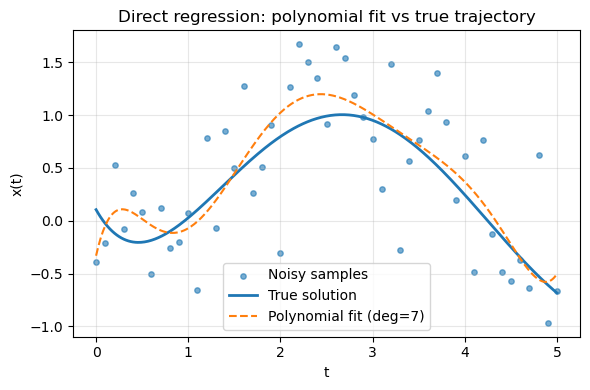

In [3]:
# -------------------------------------------------------------------
# Direct polynomial regression
# -------------------------------------------------------------------
degree = 7  # moderate degree to avoid extreme oscillations
coeffs = np.polyfit(t, x_noisy, deg=degree)
P = np.poly1d(coeffs)

t_dense = np.linspace(0.0, 5.0, 400)
x_poly = P(t_dense)

# Plot: direct regression vs true solution
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.scatter(t, x_noisy, s=15, label="Noisy samples", alpha=0.6)
ax.plot(t_dense, x_true(t_dense), label="True solution", linewidth=2)
ax.plot(t_dense, x_poly, label=f"Polynomial fit (deg={degree})", linestyle="--")

ax.set_xlabel("t")
ax.set_ylabel("x(t)")
ax.set_title("Direct regression: polynomial fit vs true trajectory")
ax.grid(alpha=0.3)
ax.legend()

fig.tight_layout()
fig_path = os.path.join("figs", "regression_direct_vs_true.png")
fig.savefig(fig_path, dpi=200, bbox_inches="tight")
print("Saved figure:", fig_path)

plt.show()

## ODE-Based Regression

Instead of fitting \(x(t)\) directly, we exploit the ODE structure
\[
\dot{x}(t) \approx -\gamma x(t) + \sin t
\]
and estimate \(\gamma\) via least squares.

1. Estimate \(\dot{x}(t_i)\) from noisy data using finite differences.
2. Solve a linear regression problem
   \[
   \dot{x}_i \approx -\gamma x_i + \sin t_i.
   \]
3. Reconstruct \(x(t)\) from the learned ODE using forward Euler integration.


In [4]:
# -------------------------------------------------------------------
# Finite-difference approximation of x'(t)
# -------------------------------------------------------------------
def numerical_derivative(x, t):
    dxdt = np.zeros_like(x)
    dt = np.diff(t)
    # central differences for interior points
    dxdt[1:-1] = (x[2:] - x[:-2]) / (t[2:] - t[:-2])
    # one-sided at boundaries
    dxdt[0] = (x[1] - x[0]) / (t[1] - t[0])
    dxdt[-1] = (x[-1] - x[-2]) / (t[-1] - t[-2])
    return dxdt

dxdt_noisy = numerical_derivative(x_noisy, t)

# Design matrix: [ -x_noisy , sin(t) ]
A = np.column_stack([-x_noisy, np.sin(t)])
params, *_ = np.linalg.lstsq(A, dxdt_noisy, rcond=None)
gamma_est, g_coeff_est = params

print("Estimated gamma:", gamma_est)
print("Estimated forcing coefficient for sin(t):", g_coeff_est)

Estimated gamma: 0.2912166731154737
Estimated forcing coefficient for sin(t): 0.9201339513344114


Saved figure: figs/regression_ode_vs_true.png


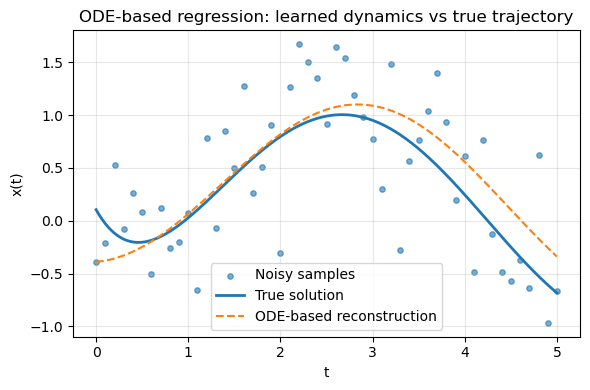

In [5]:
# -------------------------------------------------------------------
# Reconstruct x(t) using the learned ODE (forward Euler)
#   x'(t) = -gamma_est * x(t) + g_coeff_est * sin(t)
# -------------------------------------------------------------------
dt = t[1] - t[0]
x_ode = np.zeros_like(t)
x_ode[0] = x_noisy[0]  # use first noisy point as initial condition

for i in range(len(t) - 1):
    rhs = -gamma_est * x_ode[i] + g_coeff_est * np.sin(t[i])
    x_ode[i+1] = x_ode[i] + dt * rhs

# Interpolate ODE solution on dense grid for smoother plotting
# (simple linear interpolation)
x_ode_dense = np.interp(t_dense, t, x_ode)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.scatter(t, x_noisy, s=15, label="Noisy samples", alpha=0.6)
ax.plot(t_dense, x_true(t_dense), label="True solution", linewidth=2)
ax.plot(t_dense, x_ode_dense, label="ODE-based reconstruction", linestyle="--")

ax.set_xlabel("t")
ax.set_ylabel("x(t)")
ax.set_title("ODE-based regression: learned dynamics vs true trajectory")
ax.grid(alpha=0.3)
ax.legend()

fig.tight_layout()
fig_path = os.path.join("figs", "regression_ode_vs_true.png")
fig.savefig(fig_path, dpi=200, bbox_inches="tight")
print("Saved figure:", fig_path)

plt.show()

## Direct vs ODE-Based Fits: Side-by-Side Comparison

Finally we compare the two fitted trajectories (polynomial and ODE-based) to the
true solution in a single figure.


Saved figure: figs/regression_comparison.png


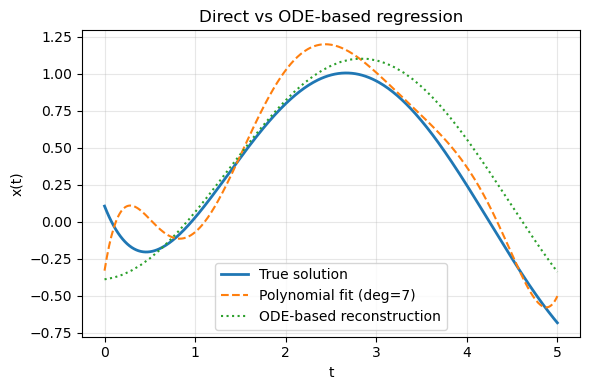

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(t_dense, x_true(t_dense), label="True solution", linewidth=2)
ax.plot(t_dense, x_poly, label=f"Polynomial fit (deg={degree})", linestyle="--")
ax.plot(t_dense, x_ode_dense, label="ODE-based reconstruction", linestyle=":")

ax.set_xlabel("t")
ax.set_ylabel("x(t)")
ax.set_title("Direct vs ODE-based regression")
ax.grid(alpha=0.3)
ax.legend()

fig.tight_layout()
fig_path = os.path.join("figs", "regression_comparison.png")
fig.savefig(fig_path, dpi=200, bbox_inches="tight")
print("Saved figure:", fig_path)

plt.show()